# Flexibility in a Search Model 

## Model

- homogeneous workers with utility $u(\cdot)$ if employed and flow (dis)utility $b$ if unemployed
- heterogeneous firms endowed with flexibility level $k \in \{0,1,..., K\}$ costing $c(k)$ with linear profit $y(x;k)-w(x;k)-c(k)$
- search parameters: discount rate $\rho$, unemployed meet firms at rate $\lambda$ (no on-the-job search), upon meeting draw match-specific productivity $x \sim G(x)$, bargaining parameter $\alpha$, employed face separation shock $\eta$


## Necessary Packages

In [1]:
# General
import numpy as np
import pandas as pd 
import scipy.stats as stats

# Graphics
import matplotlib.pyplot as plt 
import seaborn as sns

# Estimation
from scipy.optimize import minimize


## Data 
- Homogeneity measures: aged 25-55; at least college graduate; white; (maybe marital included, as it may be a concern for women?)
- employed workers earn wage $w_i$ at firm with flexibility level $k$
    - flexibility measures:
        - Schedule Flexibility 
            - 0: No flexibility in start and end times of work 
            - 1: Able to change start and end times of work 
        - Location Flexibility 
            - 0: Not able to work from home / unpaid to work from home 
            - 1:
        - Flexible Schedule Score
            - 0: No flexibility in start and end times of work 
            - 1: Informal policy allowing flexibility in start and end times of work
            - 2: Formal policy allowing for flexibility in start and end times of work
- unemployed workers have unemployment durations of $t_i$


In [2]:
df=pd.read_stata('workfile.dta', columns=['sex','employed', 'flexsched', 'flex_sched_score', 'flexloc', 'flex_loc_score', 'hrwage', 'dur'])

### Men

In [4]:
men = df[df['sex']=='male']
len(men)

1269

In [5]:
men['employed'].value_counts()

1.0    1242
0.0      27
Name: employed, dtype: int64

In [6]:
men['hrwage'].describe()

count    1242.000000
mean       42.517616
std        18.955248
min         0.008000
25%        26.923000
50%        39.423000
75%        58.173000
max        72.115250
Name: hrwage, dtype: float64

In [7]:
men['dur'].describe()

count     27.000000
mean      18.629629
std       23.348774
min        8.000000
25%       12.000000
50%       12.000000
75%       16.000000
max      131.000000
Name: dur, dtype: float64

In [8]:
fifth_pctl = np.zeros(1)

for k in range(3):
    tmp = men[men['flex_sched_score']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))
    
men['wage_trunc3']=men['hrwage']

for k in range(3):
    men['wage_trunc3'].iloc[(men['hrwage']<fifth_pctl[k+1]) & (men['flex_sched_score']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero

men['wage_trunc3'].groupby([men['employed'],men['flex_sched_score']]).describe()

5th percentile wage = 13.0 for men with flex level 0
5th percentile wage = 17.49037504196167 for men with flex level 1
5th percentile wage = 18.0 for men with flex level 2


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/3301168107.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['wage_trunc3']=men['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


count       mean        std        min     25%  \
employed flex_sched_score                                                   
1.0      0.0               341.0  35.949913  17.789873  13.000000  22.500   
         1.0               680.0  45.039341  18.127398  17.490376  30.000   
         2.0               221.0  46.191139  18.594522  18.000000  30.048   

                                 50%        75%       max  
employed flex_sched_score                                  
1.0      0.0               31.250000  47.115250  72.11525  
         1.0               43.269001  61.538250  72.11525  
         2.0               43.748001  64.903748  72.11525

In [9]:
fifth_pctl = np.zeros(1)

for k in range(2):
    tmp = men[men['flexsched']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))
    
men['wage_trunc2']=men['hrwage']

for k in range(2):
    men['wage_trunc2'].iloc[(men['hrwage']<fifth_pctl[k+1]) & (men['flexsched']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        
men['wage_trunc2'].groupby([men['employed'],men['flexsched']]).describe()

5th percentile wage = 13.0 for men with flex level 0
5th percentile wage = 17.5 for men with flex level 1


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/831430913.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['wage_trunc2']=men['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


count       mean        std   min   25%        50%  \
employed flexsched                                                       
1.0      0.0        341.0  35.949913  17.789873  13.0  22.5  31.250000   
         1.0        901.0  45.316116  18.248098  17.5  30.0  43.269001   

                         75%       max  
employed flexsched                      
1.0      0.0        47.11525  72.11525  
         1.0        62.50000  72.11525

In [10]:
fifth_pctl = np.zeros(1)

for k in range(2):
    tmp = men[men['flexloc']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))
    
men['wage_trunc_loc_2']=men['hrwage']

for k in range(2):
    men['wage_trunc_loc_2'].iloc[(men['hrwage']<fifth_pctl[k+1]) & (men['flexloc']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        
men['wage_trunc_loc_2'].groupby([men['employed'],men['flexloc']]).describe()

5th percentile wage = 14.405749797821045 for men with flex level 0
5th percentile wage = 20.192249298095703 for men with flex level 1


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/3155013116.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['wage_trunc_loc_2']=men['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


count       mean        std        min        25%  \
employed flexloc                                                      
1.0      0.0      726.0  39.096184  18.442783  14.405750  24.038250   
         1.0      516.0  47.915569  17.520315  20.192249  33.653751   

                        50%        75%       max  
employed flexloc                                  
1.0      0.0      34.615250  50.570187  72.11525  
         1.0      46.394125  64.903748  72.11525

### Women

In [11]:
women = df[df['sex']=='female']
len(women)

1239

In [12]:
fifth_pctl = np.zeros(1)

for k in range(3):
    tmp = women[women['flex_sched_score']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for women with flex level " + str(k))
    
women['wage_trunc3']=women['hrwage']

for k in range(3):
    women['wage_trunc3'].iloc[(women['hrwage']<fifth_pctl[k+1]) & (women['flex_sched_score']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero

women[['wage_trunc3','hrwage']].groupby([women['employed'],women['flex_sched_score']]).describe()    

5th percentile wage = 10.434999752044678 for women with flex level 0
5th percentile wage = 12.982499980926514 for women with flex level 1
5th percentile wage = 12.06520004272461 for women with flex level 2


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/2698806611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women['wage_trunc3']=women['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


wage_trunc3                                   \
                                count       mean        std        min   
employed flex_sched_score                                                
1.0      0.0                    488.0  29.081598  14.835706  10.434999   
         1.0                    539.0  37.236629  17.382296  12.982500   
         2.0                    185.0  34.797462  16.732208  12.065200   

                                                                    hrwage  \
                                25%        50%        75%       max  count   
employed flex_sched_score                                                    
1.0      0.0               18.75000  25.793250  35.607564  72.11525  488.0   
         1.0               23.77875  33.750000  48.076752  72.11525  539.0   
         2.0               21.90000  31.730749  44.711498  72.11525  185.0   

                                                                               \
                                mean        std      min       25%        50%   
employed flex_sched_score                                                       
1.0      0.0               28.904427  15.090322  0.01900  18.75000  25.793250   
         1.0               37.081024  17.621569  0.05275  23.77875  33.750000   
         2.0               34.618717  17.004156  3.00000  21.90000  31.730749   

                                                
                                 75%       max  
employed flex_sched_score                       
1.0      0.0               35.607564  72.11525  
         1.0               48.076752  72.11525  
         2.0               44.711498  72.11525

In [13]:
fifth_pctl = np.zeros(1)

for k in range(2):
    tmp = women[women['flexsched']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for women with flex level " + str(k))
    
women['wage_trunc2']=women['hrwage']

for k in range(2):
    women['wage_trunc2'].iloc[(women['hrwage']<fifth_pctl[k+1]) & (women['flexsched']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero

women[['wage_trunc2','hrwage']].groupby([women['employed'],women['flexsched']]).describe()        

5th percentile wage = 10.434999752044678 for women with flex level 0
5th percentile wage = 12.5 for women with flex level 1


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/501395947.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women['wage_trunc2']=women['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


wage_trunc2                                          \
                         count       mean        std        min    25%   
employed flexsched                                                       
1.0      0.0             488.0  29.081598  14.835706  10.434999  18.75   
         1.0             724.0  36.602165  17.255283  12.500000  23.00   

                                                   hrwage             \
                          50%        75%       max  count       mean   
employed flexsched                                                     
1.0      0.0        25.793250  35.607564  72.11525  488.0  28.904427   
         1.0        33.653751  48.076752  72.11525  724.0  36.451839   

                                                                               
                          std      min    25%        50%        75%       max  
employed flexsched                                                             
1.0      0.0        15.090322  0.01900  18.75  25.793250  35.607564  72.11525  
         1.0        17.487267  0.05275  23.00  33.653751  48.076752  72.11525

In [14]:
fifth_pctl = np.zeros(1)

for k in range(2):
    tmp = women[women['flexloc']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for women with flex level " + str(k))
    
women['wage_trunc_loc_2']=women['hrwage']

for k in range(2):
    women['wage_trunc_loc_2'].iloc[(women['hrwage']<fifth_pctl[k+1]) & (women['flexloc']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero

women[['wage_trunc_loc_2','hrwage']].groupby([women['employed'],women['flexloc']]).describe()        

5th percentile wage = 10.744999980926513 for women with flex level 0
5th percentile wage = 15.025 for women with flex level 1


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/2511052963.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women['wage_trunc_loc_2']=women['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


wage_trunc_loc_2                                           \
                            count       mean        std     min        25%   
employed flexloc                                                             
1.0      0.0                750.0  30.019348  15.508742  10.745  18.750000   
         1.0                462.0  39.424305  16.927986  15.025  26.432124   

                                                 hrwage                        \
                        50%        75%       max  count       mean        std   
employed flexloc                                                                
1.0      0.0      25.980750  37.925939  72.11525  750.0  29.859034  15.733701   
         1.0      36.057499  50.360563  72.11525  462.0  39.182293  17.322746   

                                                                      
                      min        25%        50%        75%       max  
employed flexloc                                                      
1.0      0.0      0.01900  18.750000  25.980750  37.925939  72.11525  
         1.0      0.05275  26.432124  36.057499  50.360563  72.11525

## Model Independent Functions

In [15]:
def lognormpdf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal pdf without stats packages
    """
    
    denom = x * σ * np.sqrt(2*np.pi)
    exp_num = -(np.log(x)-μ)**2
    exp_denom = 2 * σ * σ
    num = np.exp(exp_num/exp_denom)
    
    return num/denom

In [16]:
def lognormsf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal cdf with scipy.stats normal cdf
    """
    
    lnx = np.log(x)
    num = lnx - μ
    denom = σ
    
    return 1-stats.norm.cdf(num/denom)

In [17]:
def bootstrap(data: pd.DataFrame, n_samples:int):
    """
    Thanks, Caleb
    """
    bootstrapped_sample_list = []
    
    for n in range(n_samples):
        nth_sample = data.sample(frac=1, replace=True)
        bootstrapped_sample_list.append(nth_sample)
    
    return bootstrapped_sample_list

In [18]:
def std_error(values):
    """
    Calculates the standard error (standard deviation of values divided by square root of the number of values) of some values 
    """
    
    stderr = np.std(values) / np.sqrt(len(values))

    return stderr

In [19]:
def fit_stats(values):
    """
    
    """
    
    mean = np.mean(values)
    
    stderr = std_error(values)
    
#     ci = np.percentile(values, [2.5,97.5])# 95% C.I.

    return print("Boostrapped value ", str(mean), "\nStandard error ", str(stderr),"\n")#, "\n95% Confidence interval", str(ci)

## Utility $u(w,k; \gamma) = w(x,k) + \gamma k$ and Productivity assumption $y(x,k; \zeta) = \zeta kx$

- One issue: three variables for flexibility (cost $c$, productivity $\zeta$, and utility $\gamma$
    - Create iterative process where 2 out of 3 set by lit, find 3rd, use in next estimation to find other? 
        - Potentially issues in ordering? Fixed point argument? 
    - Remove cost $c$ by argument that TFP will account for the relative inputs and outputs ? (see notes on Bloom et al 2015)
    - Set two out of three using literature values (akin to Macro calibration)
    - 2-stage estimation? 
- Using Nelder-Mead, there is not a Hessian to calculate standard errors, so use bootstrap method 
    - Other idea: check log likelihood when only having one value to identify at a time
    

### Functions

In [20]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: float, c_k: np.array, ζ: float, γ: float, α: float, μ: float, σ: float):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - ζ: productivity weight of flexibility k
    - γ: utility weight of flexibility k
    - α: bargaining parameter
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 

    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        g = ( 1/( α*ζ*(k+1) ) ) * lognormpdf(( tmp[wage] - (1-α)*( res_wage - (γ*(k+1)) ) + α*c_k[k] )/( α*ζ*(k+1) ), μ, σ )
        G_tilde = lognormsf( ( res_wage + c_k[k] - (γ*(k+1)) )/(ζ*(k+1)), μ, σ )
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 


In [21]:
def hazard(res_wage: float, c_k: np.array, p_k: np.array, λ: float, ζ: float, γ: float, μ: float, σ: float):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - ζ: productivity weight of flexibility k
    - γ: utility weight of flexibility k    
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( res_wage + c_k[k] - (γ*(k+1)) )/(ζ*(k+1)), μ, σ ) #k+1 because Python index 0

    return λ*prob_sum

In [22]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: float, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, ζ: float, γ: float, μ: float, σ: float):
    """
    
    Inputs
    - data: DataFrame of all individuals
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - ζ: productivity weight of flexibility k
    - γ: utility weight of flexibility k   
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, ζ: float, γ: float, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array, ζ: float, γ: float, α: float, μ: float, σ: float)
    """
    
    N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, ζ, γ, α, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

In [23]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 1
η = 1
ζ = 0.25 # Estimate of TFP increase from Bloom et al (2015)
α = 0.5

### Estimation: Men, Binary Schedule Flex

In [24]:
# Utility measure for type of flex

γ = 0.6875 # Relative value of schedule flexibility to high salary from He et al (2021)

In [25]:
men['flexsched'].value_counts(normalize=True, sort=False)

1.0    0.725443
0.0    0.274557
Name: flexsched, dtype: float64

In [26]:
prob_k = np.array([0.274557, 0.725443])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

## Estimate γ, holding ζ constant and cost = 0
params = np.array([λ, η, γ, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

logL_opt = lambda x: log_L(men, 'flexsched', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
                            x[3], x[4])

est_gamma = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est_gamma.x


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:28: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, ζ, γ, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/4160224879.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  return 1-stats.norm.cdf(num/denom)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:25: RuntimeWarning: divide by zero encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:30: RuntimeWarning: divide by zero encountered in log
  Nu_log_η = data[dur].count() * np.log(η)


Optimization terminated successfully.
         Current function value: 5606.804229
         Iterations: 303
         Function evaluations: 505


array([5.43051731e-02, 1.16861226e-03, 5.36838415e-01, 5.01359970e+00,
       5.98598568e-01])

In [27]:
prob_k = np.array([0.274557, 0.725443])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

## Estimate ζ, holding γ constant and cost = 0
params = np.array([λ, η, ζ, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

logL_opt = lambda x: log_L(men, 'flexsched', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

est_zeta = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est_zeta.x


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/4160224879.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  return 1-stats.norm.cdf(num/denom)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:28: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, ζ, γ, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:25: RuntimeWarning: divide by zero encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:30: RuntimeWarning: divide by zero encountered in log
  Nu_log_η = data[dur].count() * np.log(η)


Optimization terminated successfully.
         Current function value: 5607.796193
         Iterations: 348
         Function evaluations: 617


array([5.41175643e-02, 1.16628501e-03, 4.74784929e-01, 4.37841425e+00,
       5.94505027e-01])

In [28]:
prob_k = np.array([0.274557, 0.725443])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

## Estimate c, holding γ and γ constant and cost = 0
params = np.array([λ, η, c_k[1], men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

logL_opt = lambda x: log_L(men, 'flexsched', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, α, x[1], x[2], est_zeta.x[2], est_gamma.x[2],
                            x[3], x[4])

est_c = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est_c.x


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/4160224879.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  return 1-stats.norm.cdf(num/denom)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:25: RuntimeWarning: divide by zero encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:28: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, ζ, γ, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:30: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:26: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ

Optimization terminated successfully.
         Current function value: 5604.825069
         Iterations: 570
         Function evaluations: 938


array([1.28869819e+00, 5.40272992e-02, 1.16363205e-03, 4.38900531e+00,
       5.87272364e-01])

#### Bootstrapping

In [29]:
## Estimate γ, holding ζ constant and cost = 0

prob_k = np.array([0.274557, 0.725443])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

params = np.array([λ, η, γ, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

## Bootstrapping
bootstrapped_data = bootstrap(men, n_samples=30)

logL_gamma = []
lambdas_gamma = []
etas_gamma = []
mus_gamma = []
sigmas_gamma = []
gammas = []

for sample in bootstrapped_data:
    logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_gamma.append(est.fun)
    lambdas_gamma.append(est.x[0])
    etas_gamma.append(est.x[1])
    gammas.append(est.x[2])
    mus_gamma.append(est.x[3])
    sigmas_gamma.append(est.x[4])

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/4160224879.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  return 1-stats.norm.cdf(num/denom)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:25: RuntimeWarning: divide by zero encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:30: RuntimeWarning: divide by zero encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:26: RuntimeWarning: divide by zero encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:28: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_

In [30]:
# Estimate ζ, holding γ constant and cost = 0

prob_k = np.array([0.274557, 0.725443])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

params = np.array([λ, η, ζ, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

## Bootstrapping
bootstrapped_data = bootstrap(men, n_samples=30)

logL_zetas = []
lambdas_zetas = []
etas_zetas = []
mus_zetas = []
sigmas_zetas = []
zetas = []

for sample in bootstrapped_data:
    logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

    est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
    logL_zetas.append(est.fun)
    lambdas_zetas.append(est.x[0])
    etas_zetas.append(est.x[1])
    zetas.append(est.x[2])
    mus_zetas.append(est.x[3])
    sigmas_zetas.append(est.x[4])


/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/4160224879.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  return 1-stats.norm.cdf(num/denom)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:25: RuntimeWarning: divide by zero encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, ζ, γ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:28: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, ζ, γ, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:30: RuntimeWarning: divide by zero encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_8233/1894902559.py:26: RuntimeWarning: divide by zero encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k,

#### Compare Bootstrapped Results

In [31]:
mylist = [logL_gamma, lambdas_gamma, etas_gamma, mus_gamma, sigmas_gamma, gammas]

for i in mylist:
    fit_stats(i)

Boostrapped value  5164.481493058289 
Standard error  157.5936251306104 

Boostrapped value  11.380228371910581 
Standard error  5.4422088576226555 

Boostrapped value  0.0010411936726910799 
Standard error  7.89341866173498e-05 

Boostrapped value  4.004535324939798 
Standard error  0.3630300897146187 

Boostrapped value  0.7409427628155479 
Standard error  0.04846091865354928 

Boostrapped value  -1.8603731552981784 
Standard error  0.8700665626391232 



In [32]:
mylist = [logL_zetas, lambdas_zetas, etas_zetas, mus_zetas, sigmas_zetas, zetas]

for i in mylist:
    fit_stats(i)

Boostrapped value  5840.956549494967 
Standard error  63.28901558832772 

Boostrapped value  1.071111537546347 
Standard error  0.6290093977688481 

Boostrapped value  0.0911264263753457 
Standard error  0.0383300842214422 

Boostrapped value  6.204429419550852 
Standard error  1.095963267585538 

Boostrapped value  0.9952861254412099 
Standard error  0.2024750497396861 

Boostrapped value  1.9842368704441853 
Standard error  1.2619179336272666 



/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

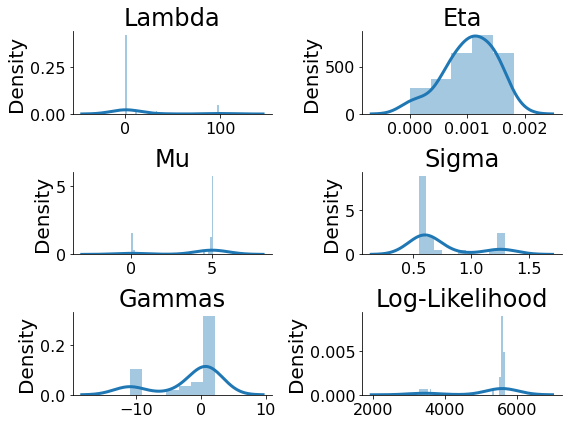

In [38]:
fig, ax = plt.subplots(3,2,figsize=(8,6))

sns.distplot(lambdas_gamma, ax=ax[0,0]).set(title="Lambda")
sns.distplot(etas_gamma, ax=ax[0,1]).set(title="Eta")
sns.distplot(mus_gamma, ax=ax[1,0]).set(title="Mu")
sns.distplot(sigmas_gamma, ax=ax[1,1]).set(title="Sigma")
sns.distplot(gammas, ax=ax[2,0]).set(title="Gammas")
sns.distplot(logL_gamma, ax=ax[2,1]).set(title="Log-Likelihood")

plt.tight_layout()

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

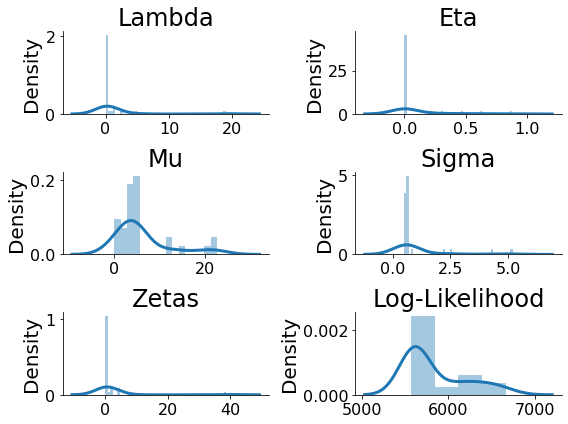

In [35]:
fig, ax = plt.subplots(3,2,figsize=(8,6))

sns.distplot(lambdas_zetas, ax=ax[0,0]).set(title="Lambda")
sns.distplot(etas_zetas, ax=ax[0,1]).set(title="Eta")
sns.distplot(mus_zetas, ax=ax[1,0]).set(title="Mu")
sns.distplot(sigmas_zetas, ax=ax[1,1]).set(title="Sigma")
sns.distplot(zetas, ax=ax[2,0]).set(title="Zetas")
sns.distplot(logL_zetas, ax=ax[2,1]).set(title="Log-Likelihood")

plt.tight_layout()

### Estimation: Men, Binary Location Flex

In [ ]:
# Utility measure for type of flex

γ = 0.625 # Relative value of location flexibility to high salary from He et al (2021)

In [ ]:
men['flexloc'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.584541, 0.415459])

# Set cost = 0

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

## Estimate γ, holding ζ constant
params = np.array([λ, η, γ, men['wage_trunc_loc_2'].mean(), men['wage_trunc_loc_2'].std()])

logL_opt = lambda x: log_L(men, 'flexloc', 'wage_trunc_loc_2', 'dur', men['wage_trunc_loc_2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x

# ## Bootstrapping
# bootstrapped_data = bootstrap(men, n_samples=30)

# logL = []
# lambdas = []
# etas = []
# mus = []
# sigmas = []
# gammas = []

# for sample in bootstrapped_data:
#     logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
#                             np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
#                             x[3], x[4])

#     est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
#     logL.append(est.fun)
#     lambdas.append(est.x[0])
#     etas.append(est.x[1])
#     gammas.append(est.x[2])
#     mus.append(est.x[3])
#     sigmas.append(est.x[4])

# mylist = [logL, lambdas, etas, mus, sigmas, gammas]

# for i in mylist:
#     fit_stats(i)

In [ ]:
prob_k = np.array([0.584541, 0.415459])

# Set cost = 0

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

## Estimate ζ, holding γ constant
params = np.array([λ, η, ζ, men['wage_trunc_loc_2'].mean(), men['wage_trunc_loc_2'].std()])

logL_opt = lambda x: log_L(men, 'flexloc', 'wage_trunc_loc_2', 'dur', men['wage_trunc_loc_2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x

# ## Bootstrapping
# bootstrapped_data = bootstrap(men, n_samples=30)

# logL = []
# lambdas = []
# etas = []
# mus = []
# sigmas = []
# zetas = []

# for sample in bootstrapped_data:
#     logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
#                             np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
#                             x[3], x[4])

#     est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
#     logL.append(est.fun)
#     lambdas.append(est.x[0])
#     etas.append(est.x[1])
#     zetas.append(est.x[2])
#     mus.append(est.x[3])
#     sigmas.append(est.x[4])

# mylist = [logL, lambdas, etas, mus, sigmas, zetas]

# for i in mylist:
#     fit_stats(i)

### Estimation: Women, Binary Schedule Flex

In [ ]:
# Utility measure for type of flex

γ = 0.6875 # Relative value of schedule flexibility to high salary from He et al (2021)

In [ ]:
women['flexsched'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.40264, 0.59736])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

## Estimate γ, holding ζ constant and setting cost = 0
params = np.array([λ, η, γ, women['wage_trunc2'].mean(), women['wage_trunc2'].std()])

logL_opt = lambda x: log_L(women, 'flexsched', 'wage_trunc2', 'dur', women['wage_trunc2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], 1.28, x[2], 
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x

# ## Bootstrapping
# bootstrapped_data = bootstrap(men, n_samples=30)

# logL = []
# lambdas = []
# etas = []
# mus = []
# sigmas = []
# gammas = []

# for sample in bootstrapped_data:
#     logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
#                             np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
#                             x[3], x[4])

#     est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
#     logL.append(est.fun)
#     lambdas.append(est.x[0])
#     etas.append(est.x[1])
#     gammas.append(est.x[2])
#     mus.append(est.x[3])
#     sigmas.append(est.x[4])

# mylist = [logL, lambdas, etas, mus, sigmas, gammas]

# for i in mylist:
#     fit_stats(i)

In [ ]:
prob_k = np.array([0.40264, 0.59736])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

## Estimate ζ, holding γ constant and setting cost=0
params = np.array([λ, η, ζ, women['wage_trunc2'].mean(), women['wage_trunc2'].std()])

logL_opt = lambda x: log_L(women, 'flexsched', 'wage_trunc2', 'dur', women['wage_trunc2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], -.144,
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x

# ## Bootstrapping
# bootstrapped_data = bootstrap(men, n_samples=30)

# logL = []
# lambdas = []
# etas = []
# mus = []
# sigmas = []
# zetas = []

# for sample in bootstrapped_data:
#     logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
#                             np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
#                             x[3], x[4])

#     est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
#     logL.append(est.fun)
#     lambdas.append(est.x[0])
#     etas.append(est.x[1])
#     zetas.append(est.x[2])
#     mus.append(est.x[3])
#     sigmas.append(est.x[4])

# mylist = [logL, lambdas, etas, mus, sigmas, zetas]

# for i in mylist:
#     fit_stats(i)

### Estimation: Women, Binary Location Flex

In [ ]:
# Utility measure for type of flex

γ = 0.625 # Relative value of location flexibility to high salary from He et al (2021)

In [ ]:
women['flexloc'].value_counts(normalize=True, sort=False)

In [ ]:
## STRANGEST OUTPUT!

prob_k = np.array([0.618812, 0.381188])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

# Estimate γ, holding ζ constant and setting cost = 0
params = np.array([λ, η, γ, women['wage_trunc_loc_2'].mean(), women['wage_trunc_loc_2'].std()])

logL_opt = lambda x: log_L(women, 'flexloc', 'wage_trunc_loc_2', 'dur', women['wage_trunc_loc_2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2], 
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x

# ## Bootstrapping
# bootstrapped_data = bootstrap(men, n_samples=30)

# logL = []
# lambdas = []
# etas = []
# mus = []
# sigmas = []
# gammas = []

# for sample in bootstrapped_data:
#     logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
#                             np.array([0,0]), prob_k, α, x[0], x[1], ζ, x[2],
#                             x[3], x[4])

#     est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
#     logL.append(est.fun)
#     lambdas.append(est.x[0])
#     etas.append(est.x[1])
#     gammas.append(est.x[2])
#     mus.append(est.x[3])
#     sigmas.append(est.x[4])

# mylist = [logL, lambdas, etas, mus, sigmas, gammas]

# for i in mylist:
#     fit_stats(i)

In [ ]:
prob_k = np.array([0.618812, 0.381188])

Bounds = ((0,99), (0,99), (-99,99), (0,99), (0,99))

## Estimate ζ, holding γ constant and setting cost=0
params = np.array([λ, η, ζ, women['wage_trunc_loc_2'].mean(), women['wage_trunc_loc_2'].std()])

logL_opt = lambda x: log_L(women, 'flexloc', 'wage_trunc_loc_2', 'dur', women['wage_trunc_loc_2'].min(), 
                            np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
                            x[3], x[4])

est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000, 'disp':True}, bounds=Bounds)
est.x

# ## Bootstrapping
# bootstrapped_data = bootstrap(men, n_samples=30)

# logL = []
# lambdas = []
# etas = []
# mus = []
# sigmas = []
# zetas = []

# for sample in bootstrapped_data:
#     logL_opt = lambda x: log_L(sample, 'flexsched', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
#                             np.array([0,0]), prob_k, α, x[0], x[1], x[2], γ,
#                             x[3], x[4])

#     est = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':1000}, bounds=Bounds)
    
#     logL.append(est.fun)
#     lambdas.append(est.x[0])
#     etas.append(est.x[1])
#     zetas.append(est.x[2])
#     mus.append(est.x[3])
#     sigmas.append(est.x[4])

# mylist = [logL, lambdas, etas, mus, sigmas, zetas]

# for i in mylist:
#     fit_stats(i)

### Estimation: Men, K=3

In [ ]:
men['flex_sched_score'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.274557, 0.547504, 0.177939])

In [ ]:
# Two-stage estimation

## Labor Market Variables in the first stage
Bounds1 = ((0,999), (0,999), (0,999), (0,999))

params1 = np.array([λ, η, men['wage_trunc3'].mean(), men['wage_trunc3'].std()])

logL_opt1 = lambda x: log_L(men, 'flex_sched_score', 'wage_trunc3', 'dur', men['wage_trunc3'].min(), 
                            np.array([0,7,10]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est4 = minimize(logL_opt1, params1, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds1)

## Flexibility Variables in the second stage
params2 = np.array([c_k[1], c_k[2], ζ, γ])

logL_opt2 = lambda x: log_L(men, 'flex_sched_score', 'wage_trunc3', 'dur', men['wage_trunc3'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, α, est4.x[0], est4.x[1], x[2], x[3],
                            est4.x[2], est4.x[3])

est4_second = minimize(logL_opt2, params2, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
print("Men's Labor market variables [λ, η, μ, σ] = "+ str(est4.x))
print("Men's Flexibility variables [c(1), c(2), ζ, γ] = "+ str(est4_second.x))

### Estimation: Women, K=3 
Estimation is finding $\mu=0$

In [ ]:
women['flex_sched_score'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.402640, 0.444719, 0.152640])

In [ ]:
# Two-stage estimation

# Labor Market Variables in the first stage
Bounds1 = ((0,999), (0,999), (0,999), (0,999))

params1 = np.array([λ, η, women['wage_trunc3'].mean(), women['wage_trunc3'].std()])

logL_opt1 = lambda x: log_L(women, 'flex_sched_score', 'wage_trunc3', 'dur', women['wage_trunc3'].min(), 
                            np.array([0,7,10]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est4 = minimize(logL_opt1, params1, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds1)

# Flexibility Variables in the second stage
params2 = np.array([c_k[1], c_k[2], ζ, γ])

logL_opt2 = lambda x: log_L(women, 'flex_sched_score', 'wage_trunc3', 'dur', women['wage_trunc3'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, α, est4.x[0], est4.x[1], x[2], x[3],
                            est4.x[2], est4.x[3])

est4_second = minimize(logL_opt2, params2, method='Nelder-Mead', options={'maxiter':1000, 'disp':True})

In [ ]:
print("Women's Labor market variables [λ, η, μ, σ] = "+ str(est4.x))
print("Women's Flexibility variables [c(1), c(2), ζ, γ] = "+ str(est4_second.x))

## Utility Linear in wage and Productivity assumption $y(x;k) = kx$

### Functions

In [ ]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: float, c_k: np.array, α: float, μ: float, σ: float):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - α: bargaining parameter
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 

    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage + α*c_k[k] ), μ, σ )
        G_tilde = lognormsf( ( 1/(k+1) )*( res_wage + c_k[k] ), μ, σ )
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 

In [ ]:
def hazard(res_wage: float, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage + c_k[k]), μ, σ ) #k+1 because Python index 0

    return λ*prob_sum

In [ ]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: float, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: float, σ: float):
    """
    
    Inputs
    - data: DataFrame of all individuals
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

In [ ]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 10
η = 10

### Estimation: Men, K=3

In [ ]:
men['flex_sched_score'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.274557, 0.547504, 0.177939])

In [ ]:
params = np.array([c_k[1], c_k[2], λ, η, men['wage_trunc3'].mean(), men['wage_trunc3'].std()])

logL_opt = lambda x: log_L(men, 'flex_sched_score', 'wage_trunc3', 'dur', men['wage_trunc3'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est4 = minimize(logL_opt, params, method='Nelder-Mead')

In [ ]:
est4.success

In [ ]:
est4.x

In [ ]:
est4.fun

In [ ]:
params = np.array([c_k[1], c_k[2], λ, η, men['hrwage'].mean(), men['hrwage'].std()])

logL_opt = lambda x: log_L(men, 'flex_sched_score', 'hrwage', 'dur', men['hrwage'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est3 = minimize(logL_opt, params, method='Nelder-Mead')

In [ ]:
est3.success

In [ ]:
est3.x

In [ ]:
est3.fun

### Estimation: Men, K=2

In [ ]:
men['flex'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.274557, 0.725443])

In [ ]:
params = np.array([c_k[1], λ, η, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

logL_opt = lambda x: log_L(men, 'flex', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est2 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est2.success

In [ ]:
est2.x

In [ ]:
est2.fun

In [ ]:
params = np.array([c_k[1], λ, η, men['hrwage'].mean(), men['hrwage'].std()])

logL_opt = lambda x: log_L(men, 'flex', 'hrwage', 'dur', men['hrwage'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est1 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est1.success

In [ ]:
est1.x

In [ ]:
est1.fun

### Estimation: Women, K=3

In [ ]:
women['flex_sched_score'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.402640, 0.444719, 0.152640])

In [ ]:
params = np.array([c_k[1], c_k[2], λ, η, women['wage_trunc3'].mean(), women['wage_trunc3'].std()])

logL_opt = lambda x: log_L(women, 'flex_sched_score', 'wage_trunc3', 'dur', women['wage_trunc3'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est4 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

c_1 = 5, c_2 = 10

In [ ]:
est4.success

In [ ]:
est4.x

In [ ]:
est4.fun

In [ ]:
# Changes every time I run it for some reason.

params = np.array([c_k[1], c_k[2], λ, η, women['hrwage'].mean(), women['hrwage'].std()])

logL_opt = lambda x: log_L(women, 'flex_sched_score', 'hrwage', 'dur', women['hrwage'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est3 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est3.success

In [ ]:
est3.x

In [ ]:
est3.fun

### Estimation: Women, K=2

In [ ]:
women['flex'].value_counts(normalize=True, sort=False)

In [ ]:
prob_k = np.array([0.40264, 0.59736])

In [ ]:
# Also changes every time I run it

params = np.array([c_k[1], λ, η, women['wage_trunc2'].mean(), women['wage_trunc2'].std()])

logL_opt = lambda x: log_L(women, 'flex', 'wage_trunc2', 'dur', women['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est2 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est2.success

In [ ]:
est2.x

In [ ]:
est2.fun

In [ ]:
# Consistent across runs

params = np.array([c_k[1], λ, η, women['hrwage'].mean(), women['hrwage'].std()])

logL_opt = lambda x: log_L(women, 'flex', 'hrwage', 'dur', women['hrwage'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est1 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

In [ ]:
est1.success

In [ ]:
est1.x

In [ ]:
est1.fun

# Figures

## Flex Schedule Score (k = 3)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='male') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Hourly Wage for Men with Flexibile Schedule Score ' +str(k))

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_men_3flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Hourly Wage for Women with Flexibile Schedule Score ' +str(k))

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_women_3flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = women[(women['flex_sched_score']==k) & (women['employed']==1)]
    sns.distplot(tmp['wage_trunc3'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flex Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Truncated Hourly Wage for Women with Flexibile Schedule Score ' +str(k))

#ax.set(xlabel="Distribution of Men's Hourly Wage")

plt.tight_layout()

fig.savefig('./wageTrunc_women_3flex.png', bbox_inches='tight', transparent=True)

## Binary Flexibility Measure

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = df[(df['flex']==k) & (df['sex']=='male') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Hourly Wage for Men with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Hourly Wage for Men without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_men_2flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = df[(df['flex']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Hourly Wage for Women with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Hourly Wage for Women without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_women_2flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = men[(men['flex']==k) & (men['employed']==1)] #(df['sex']=='male') & 
    sns.distplot(tmp['wage_trunc'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Men with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Men without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./wagetrunc_men_2flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = women[(women['flex']==k) & (women['employed']==1)] #(df['sex']=='male') & 
    sns.distplot(tmp['wage_trunc2'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Women with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Women without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./wagetrunc_women_2flex.png', bbox_inches='tight', transparent=True)

# Summary Statistics

In [ ]:
agg_dict_empl_3 = {
    'hrwage': ['count', 'min', 'mean', 'std'],
    'wage_trunc3': ['min', 'mean', 'std']
}

agg_dict_empl_2 = {
    'hrwage': ['count', 'min', 'mean', 'std'],
    'wage_trunc2': ['min', 'mean', 'std']
}

agg_dict_unempl = {
    'dur': ['count', 'min', 'max', 'mean', 'std']
}

agg_dict_pos = {
    'flex_sched_score': ['count'] #want to add percent!
}

### Men

In [ ]:
print(men.groupby(['flex_sched_score']).agg(agg_dict_empl_3).to_latex(float_format="%.2f"))

In [ ]:
print(men.groupby(['flex']).agg(agg_dict_empl_2).to_latex(float_format="%.2f"))

In [ ]:
print(men.agg(agg_dict_unempl).to_latex()) # by gender

### Women

In [ ]:
print(women.groupby(['flex_sched_score']).agg(agg_dict_empl_3).to_latex(float_format="%.2f"))

In [ ]:
print(women.groupby(['flex']).agg(agg_dict_empl_2).to_latex(float_format="%.2f"))

In [ ]:
print(women.agg(agg_dict_unempl).to_latex()) # by gender

In [ ]:
print(df.groupby(df['sex']).agg(agg_dict_unempl).to_latex(float_format="%.2f")) # by gender

In [ ]:
print(empl_df.groupby(['female']).agg(agg_dict_empl).to_latex()) # all

In [ ]:
print(unempl_df.agg(agg_dict_unempl).to_latex()) # by gender

# Scratch

## Utility with wage and flex; Productivity with TFP coeff; Two-Stage Estimation

In [ ]:
# Two-stage estimation

## Labor Market Variables in the first stage
Bounds1 = ((0,999), (0,999), (0,999), (0,999))

params1 = np.array([λ, η, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

logL_opt1 = lambda x: log_L(men, 'flex', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,7]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est2 = minimize(logL_opt1, params1, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds1)

## Flexibility Variables in the second stage
params2 = np.array([c_k[1], ζ, γ])

logL_opt2 = lambda x: log_L(men, 'flex', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])

est2_second = minimize(logL_opt2, params2, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
print("Men's Labor market variables [λ, η, μ, σ] = "+ str(est2.x))
print("Men's Flexibility variables [c(1), ζ, γ] = "+ str(est2_second.x))

In [ ]:
# Two-stage estimation with bootstrapping

## Labor Market Variables in the first stage: λ, η, μ, σ
Bounds1 = ((0,999), (0,999), (0,999), (0,999))
params1 = np.array([λ, η, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

## Flexibility Variables in the second stage: c(k), ζ, γ
params2 = np.array([c_k[1], ζ, γ])

## Bootstrapping
bootstrapped_data = bootstrap(men, n_samples=30)

logL1 = []
logL2 = []
lambdas = []
etas = []
mus = []
sigmas = []
cs = []
zetas = []
gammas = []

for sample in bootstrapped_data:
    logL_opt1 = lambda x: log_L(sample, 'flex', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
                            np.array([0,7]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])
    est2 = minimize(logL_opt1, params1, method='Nelder-Mead', bounds=Bounds1)#options={'maxiter':500, 'disp':True}, 
    
    logL_opt2 = lambda x: log_L(sample, 'flex', 'wage_trunc2', 'dur', sample['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])
    est2_second = minimize(logL_opt2, params2, method='Nelder-Mead')#, options={'maxiter':500, 'disp':True}
    
    logL1.append(est2.fun)
    logL2.append(est2_second.fun)
    lambdas.append(est2.x[0])
    etas.append(est2.x[1])
    mus.append(est2.x[2])
    sigmas.append(est2.x[3])
    cs.append(est2_second.x[0])
    zetas.append(est2_second.x[1])
    gammas.append(est2_second.x[2])

mylist = [logL1, logL2, lambdas, etas, mus, sigmas, cs, zetas, gammas]

for i in mylist:
    fit_stats(i)

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(12,12))
sns.distplot(logL1, ax=ax[0,0]).set(title="Log-Likelihood of First Stage")
sns.distplot(logL2, ax=ax[0,1]).set(title="Log-Likelihood of Second Stage")
sns.distplot(lambdas, ax=ax[0,2]).set(title="Lambda")
sns.distplot(etas, ax=ax[1,0]).set(title="Eta")
sns.distplot(mus, ax=ax[1,1]).set(title="Mu")
sns.distplot(sigmas, ax=ax[1,2]).set(title="Sigma")
sns.distplot(cs, ax=ax[2,0]).set(title="Cost of Flexibility")
sns.distplot(zetas, ax=ax[2,1]).set(title="Zetas")
sns.distplot(gammas, ax=ax[2,2]).set(title="Gammas")

plt.tight_layout()

In [ ]:
# Binary flexibility

Bounds = ((0,999), (0,999), (0,999), (0,999))

params = np.array([λ, η, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

logL_opt = lambda x: log_L(men, 'flex', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,10]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est2 = minimize(logL_opt, params, method='Nelder-Mead', bounds=Bounds, options={'maxiter':5000, 'disp':True})

In [ ]:
est2.x

In [ ]:
params = np.array([c_k[1], ζ, γ])

logL_opt = lambda x: log_L(men, 'flex', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])

est2_second = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
est2_second.x

In [ ]:
# Binary flexibility

Bounds = ((0,999), (0,999), (0,999), (0,999))

params = np.array([λ, η, women['wage_trunc2'].mean(), women['wage_trunc2'].std()])

logL_opt = lambda x: log_L(women, 'flex', 'wage_trunc2', 'dur', women['wage_trunc2'].min(), 
                            np.array([0,7]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est2 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds)

In [ ]:
est2.x

In [ ]:
params = np.array([c_k[1], ζ, γ])

logL_opt = lambda x: log_L(women, 'flex', 'wage_trunc2', 'dur', women['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])

est2_second = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
est2_second.x

In [ ]:
# Two-stage estimation

## Labor Market Variables in the first stage
Bounds1 = ((0,999), (0,999), (0,999), (0,999))

params1 = np.array([λ, η, women['wage_trunc2'].mean(), women['wage_trunc2'].std()])

logL_opt1 = lambda x: log_L(women, 'flex', 'wage_trunc2', 'dur', women['wage_trunc2'].min(), 
                            np.array([0,7]), prob_k, α, x[0], x[1], ζ, γ,
                            x[2], x[3])

est2 = minimize(logL_opt1, params1, method='Nelder-Mead', options={'maxiter':500, 'disp':True}, bounds=Bounds1)

## Flexibility Variables in the second stage
params2 = np.array([c_k[1], ζ, γ])

logL_opt2 = lambda x: log_L(women, 'flex', 'wage_trunc2', 'dur', women['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, α, est2.x[0], est2.x[1], x[1], x[2],
                            est2.x[2], est2.x[3])

est2_second = minimize(logL_opt2, params2, method='Nelder-Mead', options={'maxiter':500, 'disp':True})

In [ ]:
print("Women's Labor market variables [λ, η, μ, σ] = "+ str(est2.x))
print("Women's Flexibility variables [c(1), ζ, γ] = "+ str(est2_second.x))

In [ ]:
params = np.array([c_k[1], c_k[2], λ, η, γ, men['wage_trunc3'].mean(), men['wage_trunc3'].std()])

logL_opt = lambda x: log_L(men, 'flex_sched_score', 'wage_trunc3', 'dur', men['wage_trunc3'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, α, x[2], x[3], ζ, x[4],
                            x[5], x[6])

est4 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':800})

Runs if $\zeta = 1$ and $\gamma = 0$, as in the initial model, so it is a problem of using one flexibility marker to estimate 3 flexibility measures

In [ ]:
est4.success

In [ ]:
est4

In [ ]:
est4.fun

In [ ]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 2.1
η = 2.1
μ = men['hrwage'].groupby(men['flex_sched_score']).mean().values
σ = men['hrwage'].groupby(men['flex_sched_score']).std().values

In [ ]:
logL_opt = lambda x: log_L(men, 'flex_sched_score', 'hrwage', 'dur', Uk, 
                            x[0], prob_k, 0.5, x[1], x[2],
                            x[3], x[4])

In [ ]:
params = np.array([c_k, float(λ), float(η), μ, σ])
params

In [ ]:
params[1]

In [ ]:
log_L(men, 'flex_sched_score', 'hrwage', 'dur', Uk, 
                            params[0], prob_k, 0.5, params[1], params[2],
                            params[3], params[4])

In [ ]:
logL_opt(params)

## Pr_wage_match, hazard, and logL with res_wage, mu, and sigma varying with k

In [ ]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: float, c_k: np.array, α: float, μ: float, σ: float):
# def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array, α: float, μ: np.array, σ: np.array):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - α: bargaining parameter
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 
# With U, μ and σ constant in flex level k
    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage + α*c_k[k] ), μ, σ )
        G_tilde = lognormsf( ( 1/(k+1) )*( res_wage + c_k[k] ), μ, σ )
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
# # With U, μ and σ varying with flex level k - unidentified    
#     for k in range(len(res_wage)):
#         tmp = data[data[flex]==k]
#         g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage[k] + α*c_k[k] ), μ[k], σ[k] )
#         G_tilde = lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k] ), μ[k], σ[k] )
#         divide_thing = g/G_tilde
#         employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 

In [ ]:
def hazard(res_wage: float, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float):
# def hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: np.array, σ: np.array):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
#     if len(res_wage)!=len(c_k):
#         return print("Length of res_wage and c_k do not match.")
#     elif len(res_wage)!=len(p_k):
#         return print("Length of res_wage and p_k do not match.")
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
# With U, μ and σ constant in flex level k
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage + c_k[k]), μ, σ ) #k+1 because Python index 0

# # With U, μ and σ varying with flex level k - unidentified    
#         for k in range(len(res_wage)):
#             prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k]), μ[k], σ[k] ) #k+1 because Python index 0
    
    return λ*prob_sum#[0]

In [ ]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: float, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: float, σ: float):
# def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: np.array, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array):
    """
    
    Inputs
    - data: DataFrame of all individuals
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

## Old Hazard and Log L (did not copy Pr_wage_match in time)

In [ ]:
def hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: np.array, σ: np.array):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(res_wage)!=len(c_k):
        return print("Length of res_wage and c_k do not match.")
    elif len(res_wage)!=len(p_k):
        return print("Length of res_wage and p_k do not match.")
    elif len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(res_wage)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k]), μ[k], σ[k] ) #k+1 because Python index 0
    
    return λ*prob_sum

In [ ]:
def log_L(wage: np.array, k: np.array, res_wage: np.array, c_k: np.array, p_k: np.array, dur: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array):
    """
    
    Inputs
    - wage: Ne x 1 array of observed wage data 
    - k: Ne x 1 array of observed flexibility level data
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - dur: Nu x 1 array of observed unemployment duration data
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(wage: np.array, k: np.array, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = len(wage) * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = len(wage) * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(wage, k, res_wage, c_k,  α, μ, σ) ) )
    
    Nu_log_η = len(dur) * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(dur)
    
    logL = N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data
    
    return logL

In [ ]:
empl_men = men[men['employed']==1]
len(empl_men)

In [ ]:
unempl_men = men[men['employed']==0]
len(unempl_men)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
    ax[k].legend(['Flex Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])


#ax.set(xlabel="Distribution of Men's Hourly Wage")

plt.tight_layout()

# fig.savefig('./figures/wage_noMin.png', bbox_inches='tight', transparent=True)